 # Code to do text to speech convertion.
 you will convert text to mp4 file. Refer to link: https://pypi.org/project/pyttsx3/. refer to the link: https://thinkinfi.com/convert-text-to-speech-with-deep-learning-in-python/ which has many techniques. this link shows the deep learning based technique which uses tecttron from nvidia. We also have another library https://github.com/coqui-ai/TTS using deep learning. using tensorflow : https://github.com/TensorSpeech/TensorFlowTTS



In [1]:
!pip install rake-nltk


## TensorflowTTS real time E2E-TTS demonstration


## Install

In [ ]:
import os
!git clone https://github.com/TensorSpeech/TensorFlowTTS
os.chdir("TensorFlowTTS")
!pip install  .
os.chdir("..")
import sys
sys.path.append("TensorFlowTTS/")

In [ ]:
!pip install git+https://github.com/repodiac/german_transliterate.git#egg=german_transliterate

In [ ]:
!pip install h5py==2.10.0

## Download pretrained feature generation model

You can select one from two models. Please only run the seletected model cells.


### (b) MelGAN + STFT Loss

In [ ]:
print("Downloading MelGAN-STFT model...")
!gdown --id {"1WB5iQbk9qB-Y-wO8BU6S2TnRiu4VU5ys"} -O melgan.stft-2M.h5
!gdown --id {"1OqdrcHJvtXwNasEZP7KXZwtGUDXMKNkg"} -O melgan.stft_config.yml

## Load Model

In [ ]:
!pip install jamo
!pip install unidecode
!pip install tensorflow-addons


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pypinyin
!pip install g2p-en


In [ ]:
!apt-get install -y gcc g++
# !cmake
# !cython


In [ ]:
!apt-get install -y open-jtalk
!apt-get install -y open-jtalk-mecab-naist-jdic hts-voice-nitech-jp-atr503-m001
!apt-get install -y sox


In [ ]:
!pip install pyopenjtalk
!apt-get install -y open-jtalk
!apt-get install -y open-jtalk-mecab-naist-jdic hts-voice-nitech-jp-atr503-m001
!apt-get install -y sox
!pip install unidecode numpy
!git clone https://github.com/r9y9/pyopenjtalk.git
%cd pyopenjtalk
!pip install.


In [ ]:
!pip install pyopenjtalk-binary


In [ ]:
!pip install tensorflow-tts
!pip install tensorflow==2.4.0
!pip install tensorflow-addons==0.11.2
!pip install unidecode==1.2.0
!pip install pypinyin==0.42.0
!pip install g2p_en==2.1.0


In [ ]:
!pip install huggingface_hub


In [ ]:
#changed directory to store all the models in TensorFlowTTS there

%cd "/content/TensorFlowTTS"

/content/TensorFlowTTS


In [ ]:
import tensorflow as tf

import yaml
import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd

from tensorflow_tts.inference import TFAutoModel
from tensorflow_tts.inference import AutoConfig
from tensorflow_tts.inference import AutoProcessor

### (a) Tacotron 2

In [ ]:
tacotron2 = TFAutoModel.from_pretrained("tensorspeech/tts-tacotron2-ljspeech-en", name="tacotron2")

### (b) FastSpeech

In [ ]:
fastspeech = TFAutoModel.from_pretrained("tensorspeech/tts-fastspeech-ljspeech-en", name="fastspeech")

### (c) FastSpeech2

In [ ]:
fastspeech2 = TFAutoModel.from_pretrained("tensorspeech/tts-fastspeech2-ljspeech-en", name="fastspeech2")

### (d) MelGAN Original

In [ ]:
melgan = TFAutoModel.from_pretrained("tensorspeech/tts-melgan-ljspeech-en", name="melgan")

### (e) MelGAN STFT

In [ ]:
melgan_stft_config = AutoConfig.from_pretrained('/content/TensorFlowTTS/examples/melgan_stft/conf/melgan_stft.v1.yaml')
%cd "/content"
melgan_stft = TFAutoModel.from_pretrained(
    config=melgan_stft_config,
    pretrained_path="melgan.stft-2M.h5",
    name="melgan_stft"
)

### (f) Multi-band MelGAN

In [ ]:
mb_melgan = TFAutoModel.from_pretrained("tensorspeech/tts-mb_melgan-ljspeech-en", name="mb_melgan")


## Inference
- The first time model run inference will very slow cause by @tf.function.

In [ ]:
#Help in encoding of text give every word a unique numerical id

processor = AutoProcessor.from_pretrained("tensorspeech/tts-tacotron2-ljspeech-en")

In [ ]:
def do_synthesis(input_text, text2mel_model, vocoder_model, text2mel_name, vocoder_name):
  input_ids = processor.text_to_sequence(input_text)

  # text2mel part
  if text2mel_name == "TACOTRON":
    _, mel_outputs, stop_token_prediction, alignment_history = text2mel_model.inference(
        tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        tf.convert_to_tensor([len(input_ids)], tf.int32),
        tf.convert_to_tensor([0], dtype=tf.int32)
    )
  elif text2mel_name == "FASTSPEECH":
    mel_before, mel_outputs, duration_outputs = text2mel_model.inference(
        input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
        speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    )
  elif text2mel_name == "FASTSPEECH2":
    mel_before, mel_outputs, duration_outputs, _, _ = text2mel_model.inference(
        tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
        speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
        f0_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
        energy_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    )
  else:
    raise ValueError("Only TACOTRON, FASTSPEECH, FASTSPEECH2 are supported on text2mel_name")

  # vocoder part
  if vocoder_name == "MELGAN" or vocoder_name == "MELGAN-STFT":
    audio = vocoder_model(mel_outputs)[0, :, 0]
  elif vocoder_name == "MB-MELGAN":
    audio = vocoder_model(mel_outputs)[0, :, 0]
  else:
    raise ValueError("Only MELGAN, MELGAN-STFT and MB_MELGAN are supported on vocoder_name")

  if text2mel_name == "TACOTRON":
    return mel_outputs.numpy(), alignment_history.numpy(), audio.numpy()
  else:
    return mel_outputs.numpy(), audio.numpy()

def visualize_attention(alignment_history):
  import matplotlib.pyplot as plt

  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111)
  ax.set_title(f'Alignment steps')
  im = ax.imshow(
      alignment_history,
      aspect='auto',
      origin='lower',
      interpolation='none')
  fig.colorbar(im, ax=ax)
  xlabel = 'Decoder timestep'
  plt.xlabel(xlabel)
  plt.ylabel('Encoder timestep')
  plt.tight_layout()
  plt.show()
  plt.close()

def visualize_mel_spectrogram(mels):
  mels = tf.reshape(mels, [-1, 80]).numpy()
  fig = plt.figure(figsize=(10, 8))
  ax1 = fig.add_subplot(311)
  ax1.set_title(f'Predicted Mel-after-Spectrogram')
  im = ax1.imshow(np.rot90(mels), aspect='auto', interpolation='none')
  fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
  plt.show()
  plt.close()

In [ ]:
#Input Text

input_text = "The examination and testimony of the experts enabled the Commission to conclude that five shots may have been fired,"

In [ ]:
# setup window for tacotron2 if you want to try

tacotron2.setup_window(win_front=10, win_back=10)

In [ ]:
#Package used to compute  MCD score

!pip install -U pymcd

In [ ]:
import time
from pymcd.mcd import Calculate_MCD
from scipy.io import wavfile

### (a) Tacotron2 + MELGAN

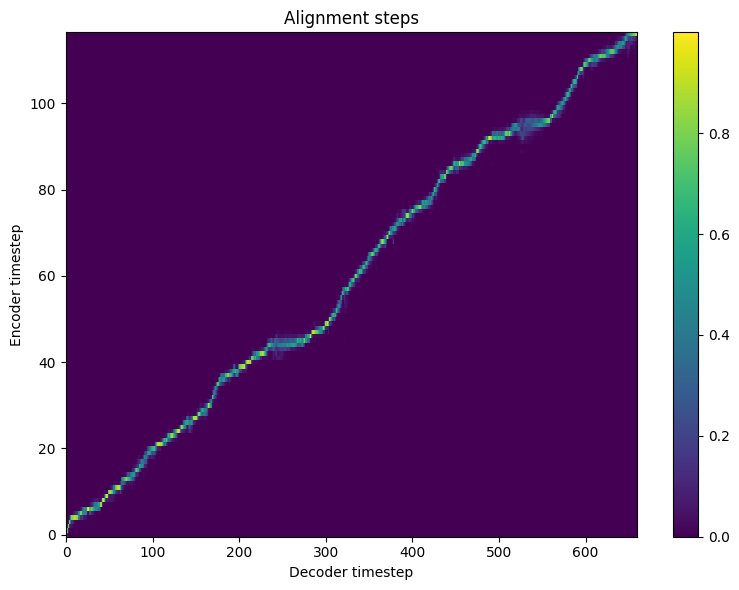

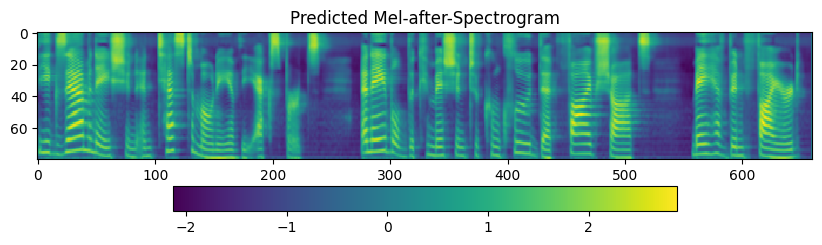

In [ ]:
start_time = time.time()
mels, alignment_history, audios = do_synthesis(input_text, tacotron2, melgan, "TACOTRON", "MELGAN")
visualize_attention(alignment_history[0])
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)
end_time = time.time()

**MCD score and Inference time Computation**

In [ ]:
# Calculation of MCD

mcd_toolbox = Calculate_MCD(MCD_mode="plain")
wavfile.write("output_audio.wav", 22050, audios)
# two inputs w.r.t. reference (ground-truth) and synthesized speeches, respectively

mcd_value = mcd_toolbox.calculate_mcd("/content/LJ037-0171.wav", "/content/output_audio.wav")

In [ ]:
# MCD Score and computation time
print("MCD score Tacotron2 + MELGAN=",mcd_value)
inference_time = end_time - start_time
print(f"Inference Time: {inference_time} seconds")

MCD score Tacotron2 + MELGAN= 16.443414776330947
Inference Time: 7.588048696517944 seconds


### (b) Tacotron2 + MELGAN-STFT

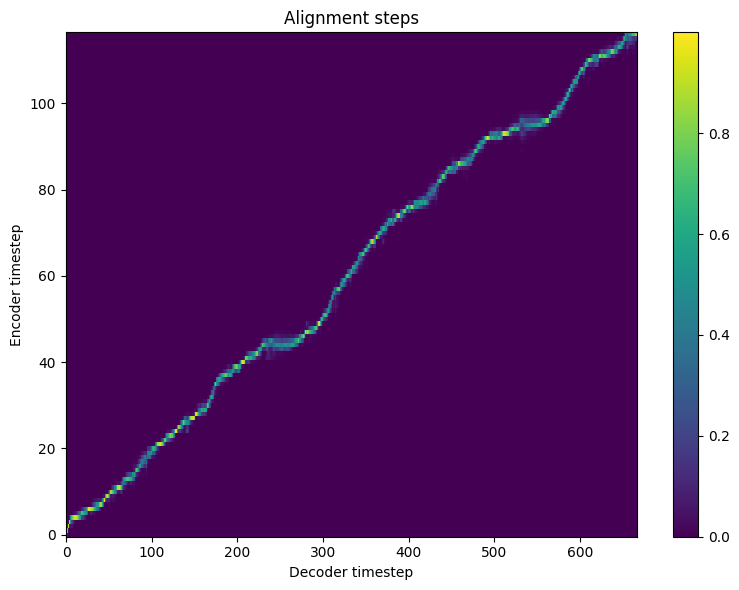

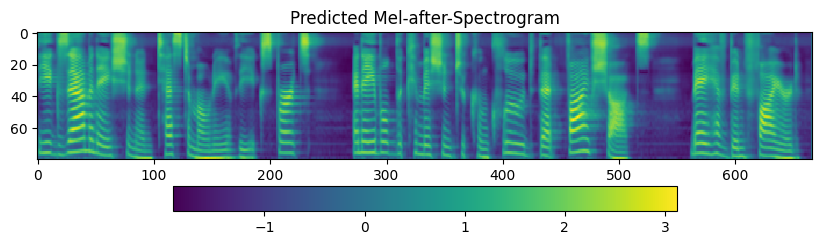

In [ ]:
start_time = time.time()
mels, alignment_history, audios = do_synthesis(input_text, tacotron2, melgan_stft, "TACOTRON", "MELGAN-STFT")
visualize_attention(alignment_history[0])
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)
end_time=time.time()

**MCD score and Inference time Computation**

In [ ]:
# Calculation of MCD

mcd_toolbox = Calculate_MCD(MCD_mode="plain")
wavfile.write("output_audio1.wav", 22050, audios)
# two inputs w.r.t. reference (ground-truth) and synthesized speeches, respectively

mcd_value = mcd_toolbox.calculate_mcd("/content/LJ037-0171.wav", "/content/output_audio1.wav")


In [ ]:
# MCD Score and computation time
print("MCD score  Tacotron2 + MELGAN-STFT=",mcd_value)
inference_time = end_time - start_time
print(f"Inference Time: {inference_time} seconds")

MCD score  Tacotron2 + MELGAN-STFT= 16.85889042585272
Inference Time: 7.6723668575286865 seconds


### (c) Tacotron2 + MB-MELGAN

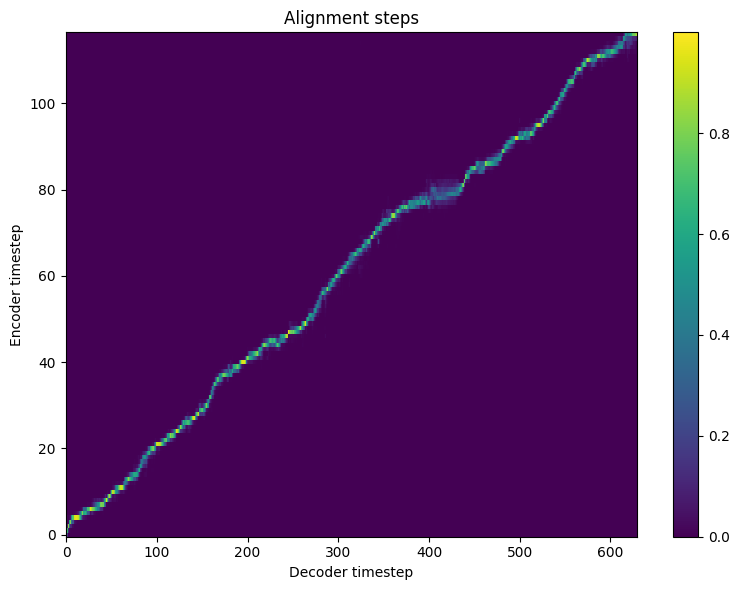

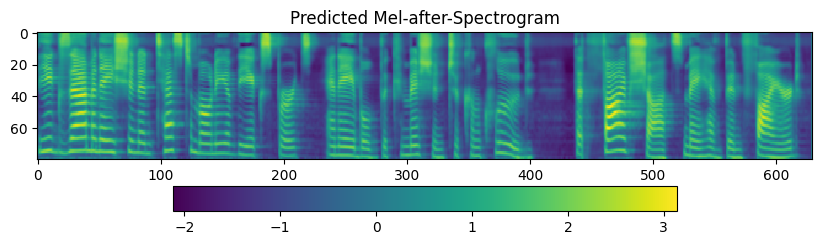

In [ ]:
start_time=time.time()
mels, alignment_history, audios = do_synthesis(input_text, tacotron2, mb_melgan, "TACOTRON", "MB-MELGAN")
visualize_attention(alignment_history[0])
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)
end_time=time.time()

**MCD score and Inference time Computation**

In [ ]:
# Calculation of MCD

mcd_toolbox = Calculate_MCD(MCD_mode="plain")
wavfile.write("output_audio2.wav", 22050, audios)
# two inputs w.r.t. reference (ground-truth) and synthesized speeches, respectively

mcd_value = mcd_toolbox.calculate_mcd("/content/LJ037-0171.wav", "/content/output_audio2.wav")

In [ ]:
# MCD Score and computation time
print("MCD score Tacotron2 + MB-MELGAN=",mcd_value)
inference_time = end_time - start_time
print(f"Inference Time: {inference_time} seconds")

MCD score Tacotron2 + MB-MELGAN= 16.319867952681413
Inference Time: 7.249122381210327 seconds


### (d) FastSpeech + MB-MELGAN

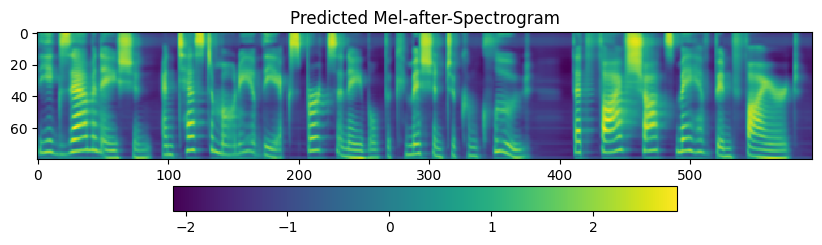

In [ ]:
start_time=time.time()
mels, audios = do_synthesis(input_text, fastspeech, mb_melgan, "FASTSPEECH", "MB-MELGAN")
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)
end_time=time.time()

**MCD score and Inference time Computation**

In [ ]:
# Calculation of MCD

mcd_toolbox = Calculate_MCD(MCD_mode="plain")
wavfile.write("output_audio3.wav", 22050, audios)
# two inputs w.r.t. reference (ground-truth) and synthesized speeches, respectively

mcd_value = mcd_toolbox.calculate_mcd("/content/LJ037-0171.wav", "/content/output_audio3.wav")

In [ ]:
# MCD Score and computation time
print("MCD score FastSpeech + MB-MELGAN=",mcd_value)
inference_time = end_time - start_time
print(f"Inference Time: {inference_time} seconds")

MCD score FastSpeech + MB-MELGAN= 17.830833764684723
Inference Time: 1.4219391345977783 seconds


### (e) FastSpeech + MELGAN-STFT

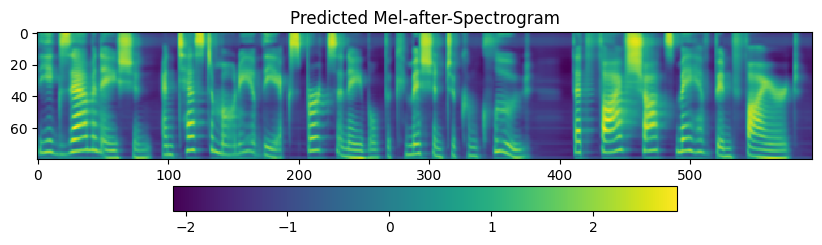

In [ ]:
start_time=time.time()
mels, audios = do_synthesis(input_text, fastspeech, melgan_stft, "FASTSPEECH", "MELGAN-STFT")
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)
end_time=time.time()

**MCD score and Inference time Computation**

In [ ]:
# Calculation of MCD

mcd_toolbox = Calculate_MCD(MCD_mode="plain")
wavfile.write("output_audio4.wav", 22050, audios)
# two inputs w.r.t. reference (ground-truth) and synthesized speeches, respectively

mcd_value = mcd_toolbox.calculate_mcd("/content/LJ037-0171.wav", "/content/output_audio4.wav")

In [ ]:
# MCD Score and computation time
print("MCD score FastSpeech + MELGAN-STFT=",mcd_value)
inference_time = end_time - start_time
print(f"Inference Time: {inference_time} seconds")

MCD score FastSpeech + MELGAN-STFT= 17.640967260934886
Inference Time: 2.3506431579589844 seconds


### (f) FastSpeech + MELGAN

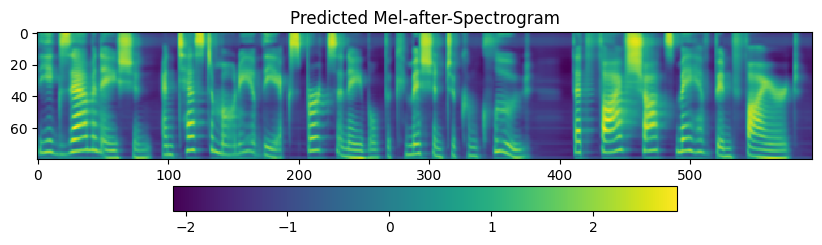

In [ ]:
start_time=time.time()
mels, audios = do_synthesis(input_text, fastspeech, melgan, "FASTSPEECH", "MELGAN")
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)
end_time=time.time()

**MCD score and Inference time Computation**

In [ ]:
# Calculation of MCD

mcd_toolbox = Calculate_MCD(MCD_mode="plain")
wavfile.write("output_audio5.wav", 22050, audios)
# two inputs w.r.t. reference (ground-truth) and synthesized speeches, respectively

mcd_value = mcd_toolbox.calculate_mcd("/content/LJ037-0171.wav", "/content/output_audio5.wav")

In [ ]:
# MCD Score and computation time
print("MCD score FastSpeech + MELGAN=",mcd_value)
inference_time = end_time - start_time
print(f"Inference Time: {inference_time} seconds")

MCD score FastSpeech + MELGAN= 17.79727427105169
Inference Time: 3.2196388244628906 seconds


### (g) FastSpeech2 + MB-MELGAN

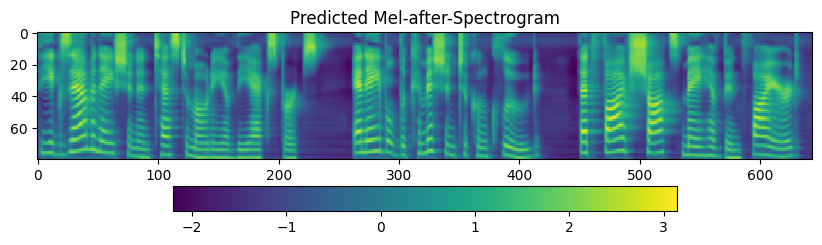

In [ ]:
start_time=time.time()
mels, audios = do_synthesis(input_text, fastspeech2, mb_melgan, "FASTSPEECH2", "MB-MELGAN")
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)
end_time=time.time()

**MCD score and Inference time Computation**

In [ ]:
# Calculation of MCD

mcd_toolbox = Calculate_MCD(MCD_mode="plain")
wavfile.write("output_audio6.wav", 22050, audios)
# two inputs w.r.t. reference (ground-truth) and synthesized speeches, respectively

mcd_value = mcd_toolbox.calculate_mcd("/content/LJ037-0171.wav", "/content/output_audio6.wav")

In [ ]:
# MCD Score and computation time
print("MCD score FastSpeech2 + MB-MELGAN=",mcd_value)
inference_time = end_time - start_time
print(f"Inference Time: {inference_time} seconds")

MCD score FastSpeech2 + MB-MELGAN= 11.642027061085349
Inference Time: 1.818901777267456 seconds


### (h) FastSpeech2 + MELGAN-STFT

In [ ]:
start_time=time.time()
mels, audios = do_synthesis(input_text, fastspeech2, melgan_stft, "FASTSPEECH2", "MELGAN-STFT")
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)
end_time=time.time()

**MCD score and Inference time Computation**

In [ ]:
# Calculation of MCD

mcd_toolbox = Calculate_MCD(MCD_mode="plain")
wavfile.write("output_audio7.wav", 22050, audios)
# two inputs w.r.t. reference (ground-truth) and synthesized speeches, respectively

mcd_value = mcd_toolbox.calculate_mcd("/content/LJ037-0171.wav", "/content/output_audio7.wav")

In [ ]:
# MCD Score and computation time
print("MCD score FastSpeech2 + MELGAN-STFT=",mcd_value)
inference_time = end_time - start_time
print(f"Inference Time: {inference_time} seconds")

MCD score FastSpeech2 + MELGAN-STFT= 11.565604874075643
Inference Time: 2.2870004177093506 seconds


### (i) FastSpeech2 + MELGAN

In [ ]:
start_time=time.time()
mels, audios = do_synthesis(input_text, fastspeech2, melgan, "FASTSPEECH2", "MELGAN")
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)
end_time=time.time()

**MCD score and Inference time Computation**

In [ ]:
# Calculation of MCD

mcd_toolbox = Calculate_MCD(MCD_mode="plain")
wavfile.write("output_audio8.wav", 22050, audios)
# two inputs w.r.t. reference (ground-truth) and synthesized speeches, respectively

mcd_value = mcd_toolbox.calculate_mcd("/content/LJ037-0171.wav", "/content/output_audio8.wav")

In [ ]:
# MCD Score and computation time
print("MCD score  FastSpeech2 + MELGAN=",mcd_value)
inference_time = end_time - start_time
print(f"Inference Time: {inference_time} seconds")

MCD score  FastSpeech2 + MELGAN= 11.573875713372976
Inference Time: 4.471189022064209 seconds


## Text to Speech with Google TTS


In [ ]:
!pip install gTTS


In [ ]:
from gtts import gTTS
# Text2Speech generation
start_time=time.time()
tts = gTTS('The examination and testimony of the experts enabled the Commission to conclude that five shots may have been fired,', lang='en')
# Save converted audio as mp3 format
tts.save('gTTSen.mp3')
end_time=time.time()

#Inference time calculation
inference_time = end_time - start_time
print(f"Inference Time: {inference_time} seconds")

Inference Time: 0.35593628883361816 seconds


In [ ]:
# Text2Speech generation
tts = gTTS('मेरा विश्वास अपने-आप में है। दोनों शाम उसी विश्वास के पात्र में भर-भर इस विश्व की अमर सुधा का मैंने पान किया है। क्षण-क्षण का प्रेम उसके भीतर संचित हुआ है। दुःख के भार से यह पात्र नहीं दरका; धूल ने उसके शिल्प को काला नहीं किया।', lang='hi')
# Save converted audio as mp3 format
tts.save('gTTShi.mp3')

## pyttsx3





















### text-to-speech conversion library in Python. Unlike alternative libraries, it works offline

In [ ]:
!pip install pyttsx3

In [ ]:
!sudo apt install espeak

In [ ]:
import pyttsx3
engine = pyttsx3.init()
engine.say("I will speak this text")
engine.runAndWait()

In [ ]:
import pyttsx3
engine = pyttsx3.init() # object creation

""" RATE"""
rate = engine.getProperty('rate')   # getting details of current speaking rate
print (rate)                        #printing current voice rate
engine.setProperty('rate', 150)     # setting up new voice rate


"""VOLUME"""
volume = engine.getProperty('volume')   #getting to know current volume level (min=0 and max=1)
print (volume)                          #printing current volume level
engine.setProperty('volume',1.0)    # setting up volume level  between 0 and 1

"""VOICE"""
voices = engine.getProperty('voices')       #getting details of current voice
#engine.setProperty('voice', voices[0].id)  #changing index, changes voices. o for male
engine.setProperty('voice', voices[1].id)   #changing index, changes voices. 1 for female

# engine.say("Natural language processing is really awesome!")
# engine.say('My current speaking rate is ' + str(rate))
# engine.runAndWait()
# engine.stop()

"""Saving Voice to a file"""
# On linux make sure that 'espeak' and 'ffmpeg' are installed
engine.save_to_file('The examination and testimony of the experts enabled the Commission to conclude that five shots may have been fired,','pyttsx31.mp3')
engine.runAndWait()



In [ ]:
import librosa
import numpy as np
output_file='pyttsx31.mp3'
audio, sr = librosa.load(output_file, sr=None)
duration = len(audio) / sr
rms = np.sqrt(np.mean(audio ** 2))
pitch = librosa.yin(audio, fmin=50, fmax=300)
pitch=np.mean(pitch)
print("Duration:", duration, "seconds")
print("RMS (Volume):", rms)
print("Pitch:", pitch)

**MALE(id=0)**

Duration: 7.9760544217687075 seconds

RMS (Volume): 0.088192835

Pitch: 122.30496310209335

**FEMALE(id=1)**

Duration: 8.298730158730159 seconds

RMS (Volume): 0.08910626

Pitch: 125.29549684789465

## Coqui Studio API is landed on 🐸TTS

In [ ]:
!pip install TTS

In [ ]:
from TTS.api import TTS
import librosa

In [ ]:

# Running a multi-speaker and multi-lingual model

# List available 🐸TTS models and choose the first one
model_name = TTS.list_models()[0]
# Init TTS
tts = TTS(model_name)
# Run TTS
# ❗ Since this model is multi-speaker and multi-lingual, we must set the target speaker and the language
# Text to speech to a file
speakers = {}
for i in range(6):
  tts.tts_to_file(text="Hello world!", speaker=tts.speakers[i], language=tts.languages[0], file_path=f"output{i}.wav")
  output_file=f"output{i}.wav"
  audio, sr = librosa.load(output_file, sr=None)
  duration = len(audio) / sr
  rms = np.sqrt(np.mean(audio ** 2))
  pitch = librosa.yin(audio, fmin=50, fmax=300)
  pitch=np.mean(pitch)
  speakers[f'speaker{i}'] = {'Pitch': pitch, 'RMS (Volume)':rms , 'Duration': duration}

# Running a single speaker model

# Init TTS with the target model name
# tts = TTS(model_name="tts_models/de/thorsten/tacotron2-DDC", progress_bar=False, gpu=False)
# Run TTS
# tts.tts_to_file(text="Ich bin eine Testnachricht.", file_path='APIttsspanish.mp3')


# Run TTS with emotion and speed control
# tts.tts_to_file(text="This is a test.", file_path='APItts.mp3', emotion="Sad", speed=1.5)

In [ ]:
#return every parameters for an individual speaker on same text

for key, value in speakers.items():
    print(key, ':', value)

**Reslts**

speaker0 : {'Pitch': 234.67723497146613, 'RMS (Volume)': 0.1620834, 'Duration': 1.489}

speaker1 : {'Pitch': 211.29828424349833, 'RMS (Volume)': 0.15190306, 'Duration': 1.633}

speaker2 : {'Pitch': 221.42887603911174, 'RMS (Volume)': 0.17056428, 'Duration': 1.489}

speaker3 : {'Pitch': 225.1808022728022, 'RMS (Volume)': 0.12335953, 'Duration': 1.297}

speaker4 : {'Pitch': 218.12079430504508, 'RMS (Volume)': 0.12076642, 'Duration': 1.329}

speaker5 : {'Pitch': 228.9117699312734, 'RMS (Volume)': 0.16833502, 'Duration': 1.185}